<h1>Time Series Forecasting</h1>

Objective: Use time series to forecast out order volume for staffing for given restaurant

In [ ]:
!pip3 install pandasql

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from pandasql import sqldf

In [4]:
pysqldf = lambda q: sqldf(q, globals())

In [6]:
orders = pd.read_csv('restaurant-1-orders.csv')
orders.columns = ['number', 'timestamp', 'item', 'quantity', 'price', 'total_products_in_cart']

In [7]:
orders.sample(2)

,number,timestamp,item,quantity,price,total_products_in_cart
69968,5532,27/05/2017 17:49,Butter Chicken,2,9.95,6
23857,7837,18/12/2017 17:25,Keema Naan,1,2.95,6


In [9]:
orders['date'] = pd.to_datetime(orders['timestamp'].str[:10],
    format='%d/%m/%Y')

In [13]:
orders.sample(2)

,number,timestamp,item,quantity,price,total_products_in_cart,date
13040,10355,19/07/2018 17:53,Tandoori Roti,2,2.60,5,2018-07-19
70879,3036,28/08/2016 18:46,Chicken Biryani,1,9.95,7,2016-08-28


In [14]:
print(f"Total number of orders in dataset: {orders['number'].nunique()}")

Total number of orders in dataset: 13397


In [15]:
def load_query(path):
    with open(path) as file:
        return file.read()

<h3>Case 1: Direct Multistep Forecasting</h3>

In [18]:
query = load_query('queries/daily_orders.sql') #total number of orders each day
daily_orders = pysqldf(query)

In [19]:
daily_orders.sample(2)

,date,num_orders
866,2018-08-27,21
1177,2019-07-05,23


In [20]:
import logging
logging.getLogger().setLevel(logging.CRITICAL) # Prevent the matplotlib infos on categorical x-axis

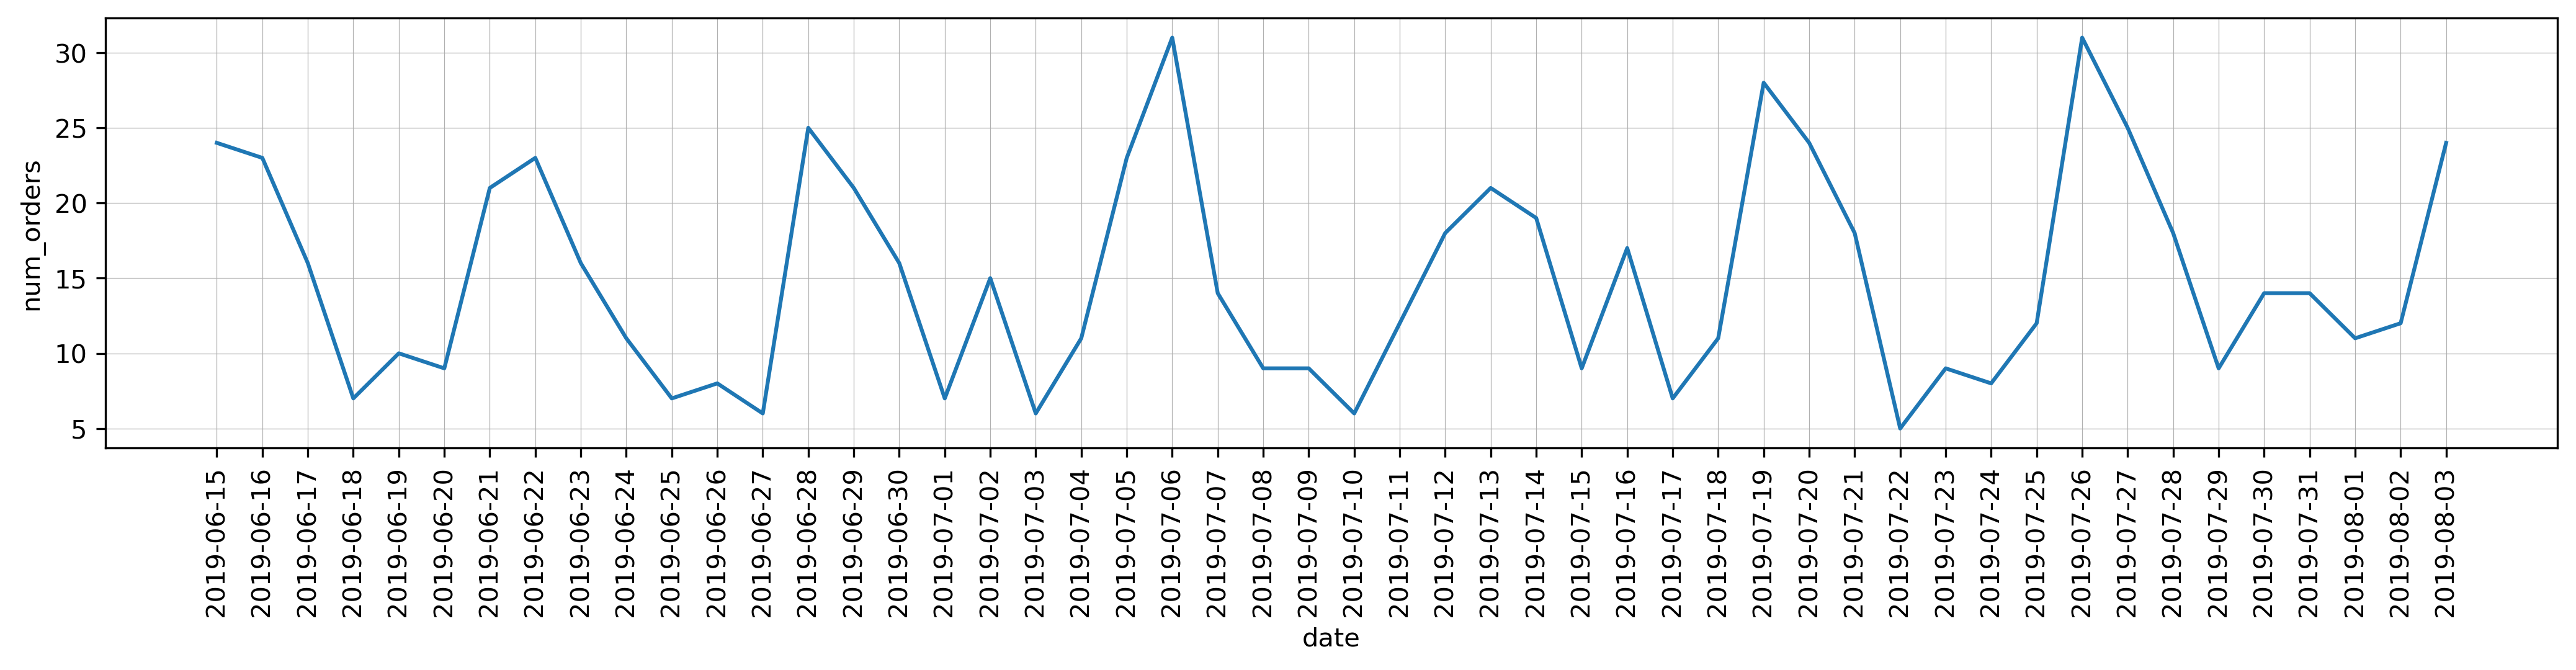

In [21]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=daily_orders.tail(50), x='date', y='num_orders')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

Daily order quantity too low to implement forecasting. Let's look at weekly order volume instead

In [22]:
query = load_query('queries/weekly_orders.sql')
weekly_orders = pysqldf(query)

In [23]:
weekly_orders.sample(2)

,week,num_orders
38,2016-11-28,62
81,2017-09-25,80


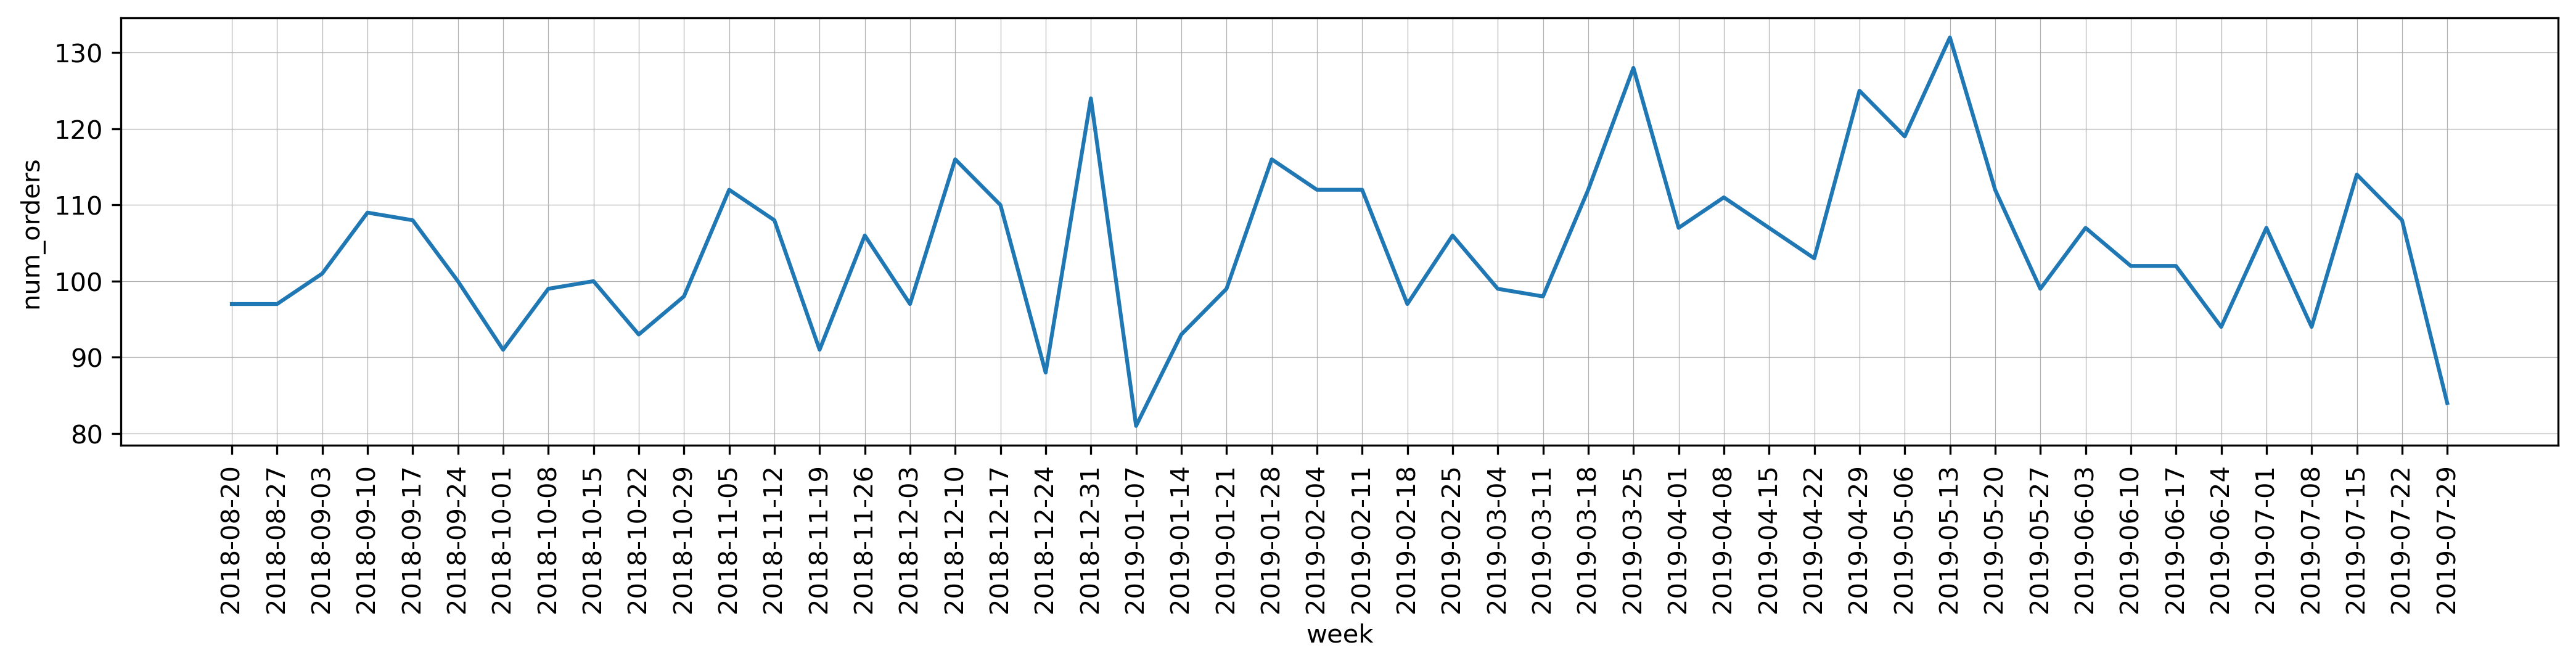

In [24]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=weekly_orders.tail(50), x='week', y='num_orders')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

Let's create our dataset

In [25]:
query = load_query('queries/base.sql')
df = pysqldf(query)
df.to_csv('dataset.csv')

In [26]:
df.sample(3)

,week,order_count_7_day,order_count_30_day,label
137,2018-11-05,98,430,112
62,2017-05-29,62,273,84
122,2018-07-23,72,354,108


In [27]:
features = ['order_count_7_day', 'order_count_30_day']
label = 'label'
test_df = df[df['week'] >= '2019-06-01']
train_df = df[df['week'] < '2019-06-01']
X_train, y_train = train_df[features], train_df[label]
X_test, y_test = test_df[features], test_df[label]

In [ ]:
reg = XGBRegressor(n_estimators=500, learning_rate=0.01)
reg.fit(X_train, 
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='mae')

In [29]:
predictions = reg.predict(X_test)

In [30]:
test_df = test_df.reset_index().drop('index', axis=1)
test_df['predictions'] = pd.Series(predictions)

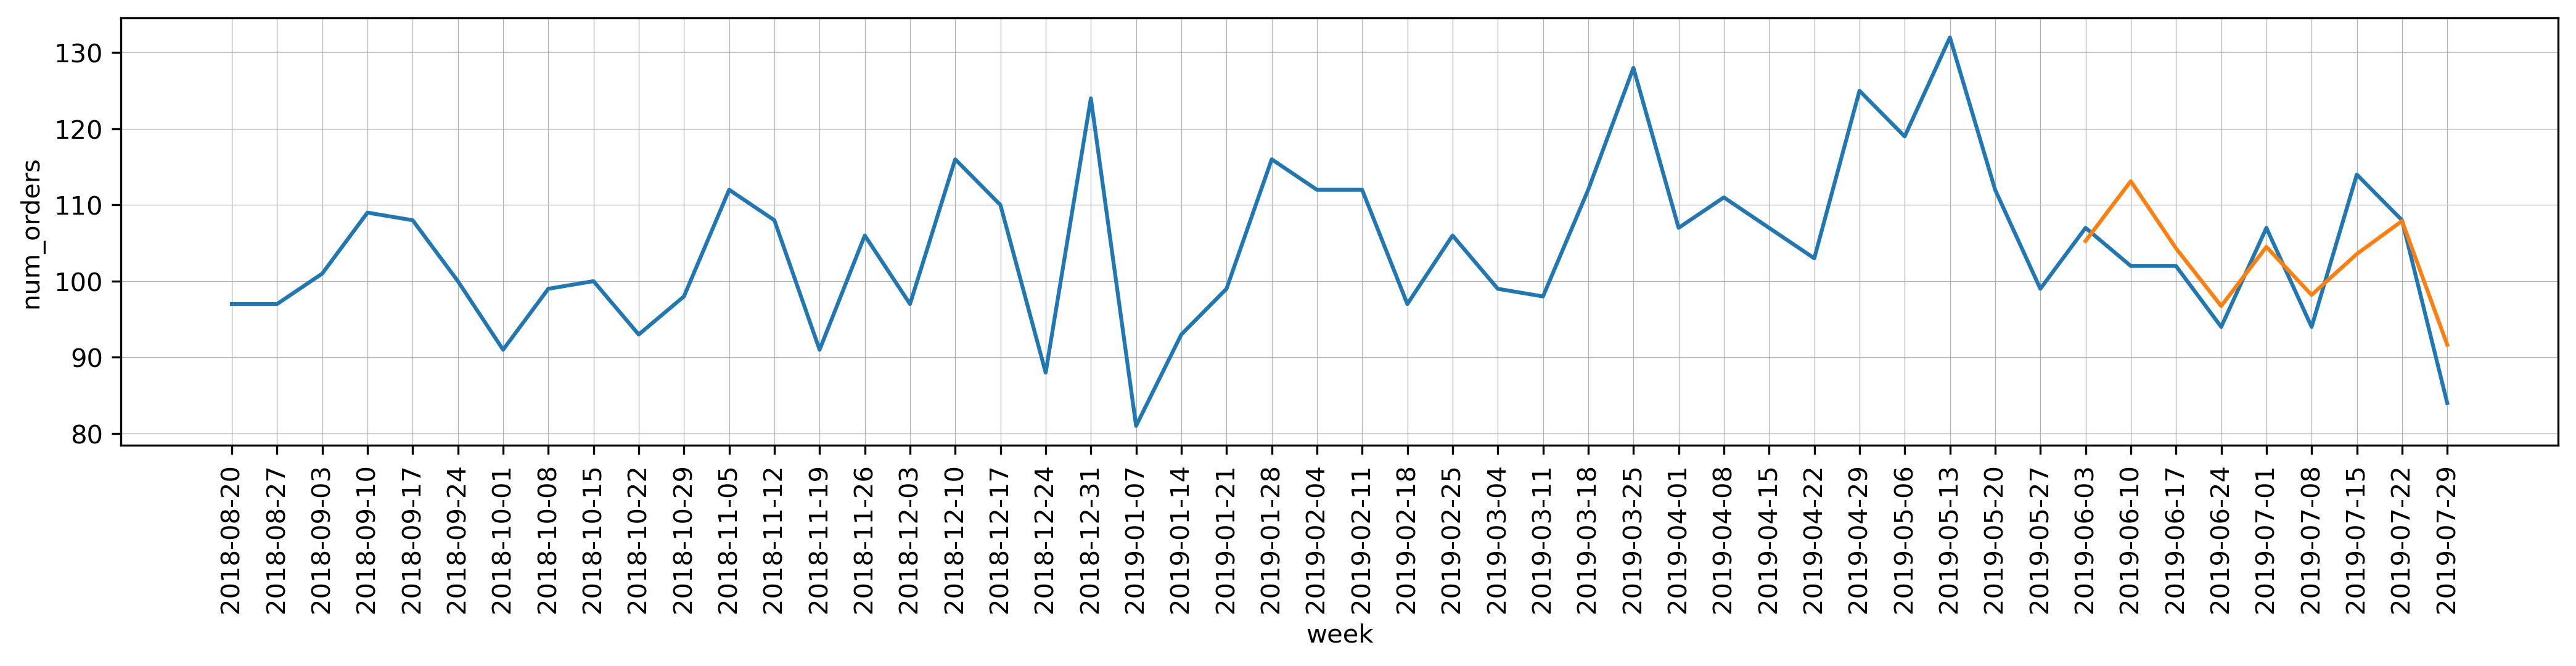

In [31]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=weekly_orders.tail(50), x='week', y='num_orders')
sns.lineplot(data=test_df, x='week', y='predictions')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

The XGBoost‐based forecast (orange) tracks the short‐term level of the series reasonably well—it rises and falls in roughly the right places.